In [85]:

from importlib import reload
from typing import List

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from serial import Serial

import spectrum_painting as sp
import spectrum_painting_data as sp_data
import spectrum_painting_model as sp_model
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Convert MATLAB data to numpy files to make loading quicker

See `convert_matlab_to_numpy.py` to do call this manually without running it in the notebook.

# Load spectrograms

In [87]:
reload(sp_training)

classes = ["Z", "B", "W", "BW", "ZB", "ZW", "ZBW"]
spectrum_painting_options = sp_training.SpectrumPaintingTrainingOptions(
    spectrogram_length=2500,
    downsample_resolution=64,
    k=3,
    l=16,
    d=4
)

In [88]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you wrote.
reload(sp_data)
reload(sp)

spectrograms = sp_data.load_spectrograms(data_dir="data/numpy",
                                         classes=classes,
                                         snr_list=[10],
                                         # 20 MHz
                                         sample_rate=20000000,
                                         count=999999999,
                                         window_length=256)

In [90]:
reload(sp)
reload(sp_plot)
reload(sp_predict)
reload(sp_training)

train_test_sets = sp_training.create_spectrum_painting_train_test_sets(
    spectrograms=spectrograms,
    options=spectrum_painting_options,
    test_size=0.3
)

print(f"Number of training images: {len(train_test_sets.y_train)}")
print(f"Number of testing images: {len(train_test_sets.y_test)}")

Removed 74 images that didn't actually contain any Bluetooth signals.
Number of training images: 1656
Number of testing images: 710


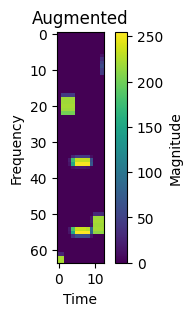

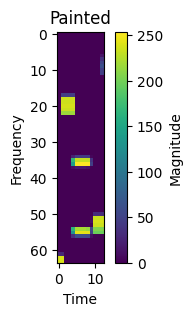

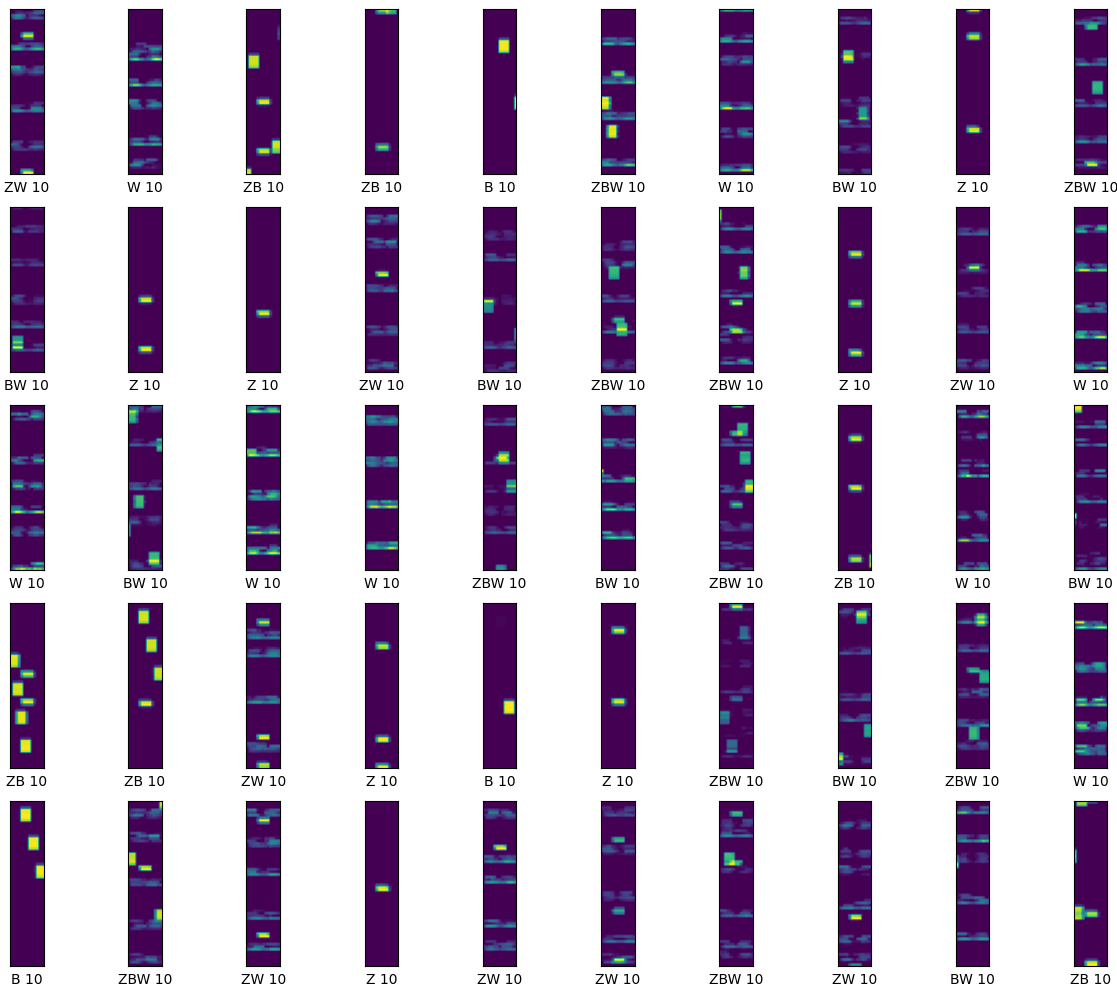

In [138]:
image_index = 2
sp_plot.plot_spectrogram(train_test_sets.x_test_augmented[image_index], "Augmented")
sp_plot.plot_spectrogram(train_test_sets.x_test_painted[image_index], "Painted")

sp_plot.plot_train_images(train_test_sets.x_test_painted,
                          train_test_sets.y_test,
                          train_test_sets.label_names,
                          train_test_sets.test_snr)

# Create TensorFlow model

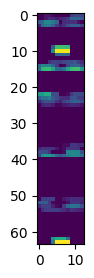

(64, 13)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 conv2d_60 (Conv2D)          (None, 64, 13, 8)            400       ['input_21[0][0]']            
                                                                                                  
 conv2d_63 (Conv2D)          (None, 64, 13, 8)            400       ['input_22[0][0]']            
                                                                                  

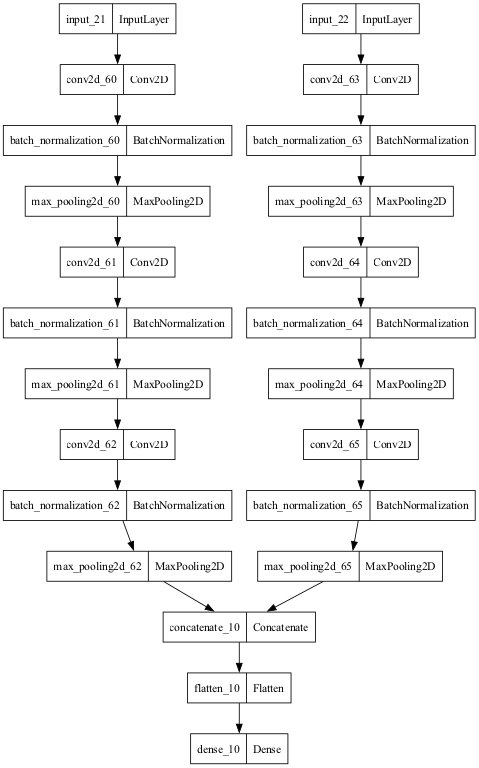

In [173]:
reload(sp_model)

plt.figure(figsize=(3, 3))
plt.imshow(train_test_sets.x_test_painted[0], cmap='viridis')
plt.show()

image_shape = train_test_sets.x_train_augmented[0].shape
print(image_shape)

tf_model = sp_model.create_tensorflow_model(image_shape=image_shape, label_count=len(train_test_sets.label_names))
tf_model.summary()
tf.keras.utils.plot_model(tf_model, to_file="output/model.png", dpi=60)


# Train the TensorFlow model

 Epoch: 29, Val. accuracy = 0.9140844941139221

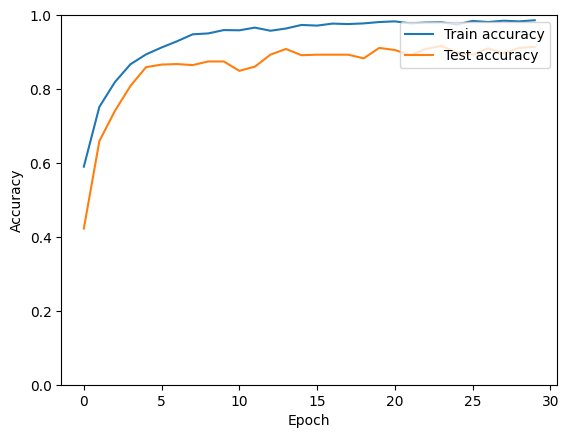

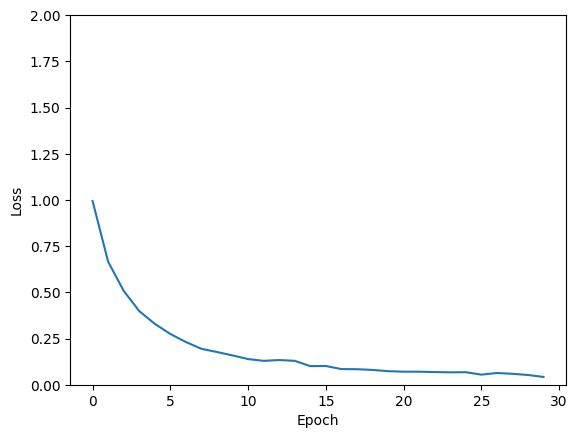

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


Final loss: 0.305262, final accuracy: 0.914084


In [175]:
reload(sp_model)
history = sp_model.fit_model(tf_model, train_test_sets, epochs=30, early_stopping_patience=10)

sp_plot.plot_model_accuracy_epochs(history)
sp_plot.plot_model_loss(history)

output_file = f"output/spectrum-painting-model-SNR-10.keras"

tf.saved_model.save(tf_model, "output/")
tf_model.save(output_file)

final_loss, final_acc = tf_model.evaluate([train_test_sets.x_test_augmented, train_test_sets.x_test_painted],
                                          train_test_sets.y_test,
                                          verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))


# Confusion matrix for TensorFlow model

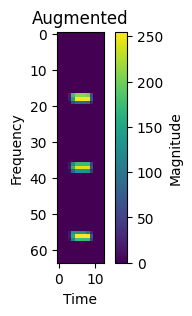

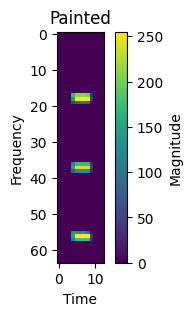

Z


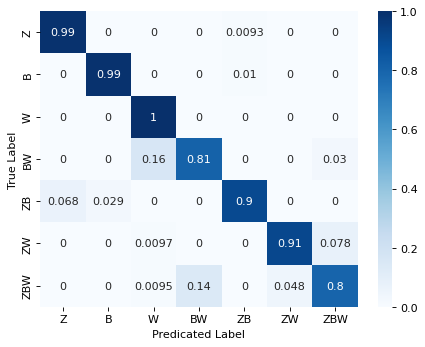

In [176]:
reload(sp_predict)
reload(sp_plot)

# Predict with full Tensorflow
test_img_augmented = train_test_sets.x_test_augmented[17]
test_img_painted = train_test_sets.x_test_painted[17]

sp_plot.plot_spectrogram(test_img_augmented, "Augmented")
sp_plot.plot_spectrogram(test_img_painted, "Painted")

prediction = sp_predict.predict_full_model(tf_model, test_img_augmented, test_img_painted)

print(train_test_sets.label_names[prediction])

tf_model_y_predictions = [sp_predict.predict_full_model(tf_model, x_a, x_p) for (x_a, x_p) in
                          zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)]

sp_plot.plot_confusion_matrix(tf_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)

# Convert to Lite model

In [182]:
reload(sp_model)
tflite_model = sp_model.convert_to_tensorflow_lite(tf_model,
                                                   train_test_sets.x_test_augmented,
                                                   train_test_sets.x_test_painted)
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

lite_output_file = f"output/spectrum-painting-model.tflite"
# Save the model.
with open(lite_output_file, "wb") as f:
    f.write(tflite_model)

# Create a hex dump of the model in a C file for the arduino.
# Use sed to make the variables const since they are huge.
! xxd -i $lite_output_file | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/model.h

INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp0kwawgvs/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp0kwawgvs/assets
/Users/sethd/Desktop/spectrum-painting/venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-06-10 13:06:20.270761: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-10 13:06:20.270779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-10 13:06:20.270924: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmp0kwawgvs
2024-06-10 13:06:20.272903: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-10 13:06:20.272909: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3

Done. Model size = 19 KB


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


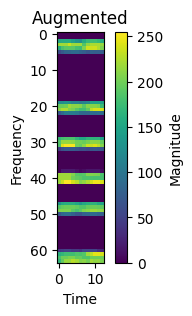

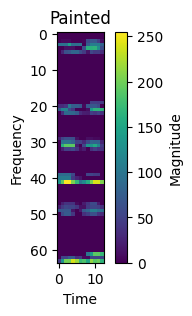

W
Prediction: W


In [183]:
reload(sp_predict)
image_index = 20

# Test with Tensorflow Lite
test_img_augmented = train_test_sets.x_test_augmented[image_index]
test_img_painted = train_test_sets.x_test_painted[image_index]

sp_plot.plot_spectrogram(test_img_augmented, "Augmented")
sp_plot.plot_spectrogram(test_img_painted, "Painted")
print(train_test_sets.label_names[train_test_sets.y_test[image_index]])

prediction = sp_predict.predict_lite_model(tflite_model, test_img_augmented, test_img_painted)
print(f"Prediction: {train_test_sets.label_names[prediction]}")

# Confusion matrix for Lite model

Lite model accuracy = 0.9112676056338028


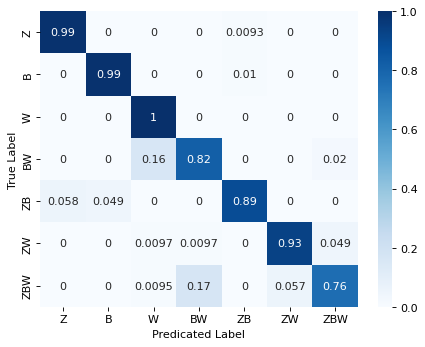

In [184]:
tflite_model_y_predictions: List[int] = []

for x_aug, x_painted in list(zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)):
    tflite_model_y_predictions.append(sp_predict.predict_lite_model(tflite_model, x_aug, x_painted))

tflite_accuracy = np.sum(train_test_sets.y_test == tflite_model_y_predictions) / len(train_test_sets.y_test)

print(f"Lite model accuracy = {tflite_accuracy}")
sp_plot.plot_confusion_matrix(np.asarray(tflite_model_y_predictions),
                              train_test_sets.y_test,
                              train_test_sets.label_names)

# Compile and upload to arduino

In [75]:
! arduino-cli compile --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino
! arduino-cli upload --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino --port /dev/cu.usbmodem2101

Library Arduino_TensorFlowLite has been declared precompiled:
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4/fpv4-sp-d16-softfp" not found
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4" not found
Sketch uses 439608 bytes (44%) of program storage space. Maximum is 983040 bytes.
Global variables use 117664 bytes (44%) of dynamic memory, leaving 144480 bytes for local variables. Maximum is 262144 bytes.

Used library           Version     Path
Arduino_TensorFlowLite 2.4.0-ALPHA /Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite
Wire                               /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0/libraries/Wire

Used platform Version Path
arduino:mbed  3.3.0   /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0
Device       : nRF52840-QIAA
Version      : Arduino Bootloader (SAM-BA extended) 2.0 [Arduino:IKXYZ]
Address 

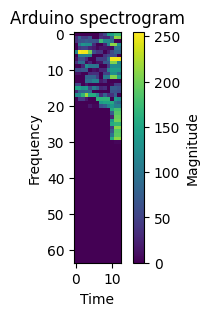

Downsample duration = 136 ms
Augment duration = 20 ms
Paint duration = 1 ms
Inference duration = 392 ms
Total duration = 549 ms
Predicted label = BW


In [132]:
serial = Serial(port="/dev/cu.usbmodem2101", baudrate=115200, timeout=1000)

arduino_spectrogram = []
for _ in range(spectrum_painting_options.downsample_resolution):
    real_line = serial.readline().decode('utf-8').strip()
    magnitudes = list(map(float, real_line.split(',')))

    arduino_spectrogram.append(magnitudes)

downsample_duration = int(serial.readline().strip())
augment_duration = int(serial.readline().strip())
paint_duration = int(serial.readline().strip())
inference_duration = int(serial.readline().strip())
total_duration = int(serial.readline().strip())
predicted_label = int(serial.readline().strip())

sp_plot.plot_spectrogram(np.asarray(arduino_spectrogram), "Arduino spectrogram")

print(f"Downsample duration = {downsample_duration} ms")
print(f"Augment duration = {augment_duration} ms")
print(f"Paint duration = {paint_duration} ms")
print(f"Inference duration = {inference_duration} ms")
print(f"Total duration = {total_duration} ms")
print(f"Predicted label = {classes[predicted_label]}")

serial.close()